In [1]:
%pip install -q matplotlib networkx pandas torchinfo

Note: you may need to restart the kernel to use updated packages.


In [5]:
import copy
import functions
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import poptorch
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from datetime import datetime
from lamah_dataset import LamaHDataset
from lamah_models import FloodMLP, FloodGCN, FloodGRAFFNN
from poptorch_geometric import FixedSizeDataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.transforms import AddSelfLoops, ToUndirected
from torch_geometric.utils import to_networkx
from torchinfo import summary
from tqdm import tqdm

In [6]:
functions.ensure_reproducibility(1)  # set to 2 and 3 for std runs

In [7]:
HPARAMS = {
    "data": {
        "window_size": 24,
        "stride_length": 6,
        "lead_time": 1,
        "bidirectional": True,
        "normalized": True
    },
    "model": {
        "architecture": "GCN",
        "propagation_dist": 19,
        "hidden_size": 128,
        "residual": True,
        "weight_type": "learned"
    },
    "training": {
        "num_epochs": 20,
        "batch_size": 16,
        "learning_rate": 0.005,
        "weight_decay": 5e-4
    }
}

In [8]:
dataset = LamaHDataset("LamaH-CE",
                       years=range(2000, 2018),
                       window_size_hrs=HPARAMS["data"]["window_size"],
                       stride_length_hrs=HPARAMS["data"]["stride_length"],
                       lead_time_hrs=HPARAMS["data"]["lead_time"],
                       bidirectional=HPARAMS["data"]["bidirectional"],
                       normalize=HPARAMS["data"]["normalized"])

Loading dataset into memory...


100%|██████████| 375/375 [00:30<00:00, 12.38it/s]


In [9]:
train_dataset = dataset.subsample_years(y for y in range(2000, 2017) if y % 8 > 0)
val_dataset = dataset.subsample_years(y for y in range(2000, 2017) if y % 8 == 0)

# training samples: 20392
# validation samples: 4380
# vertices: 375
# edges: 1123
# vertex features: 24
# edge features: 3
directed graph?: False
isolated vertices? False
self-loops? True
coalesced? True
valid? True


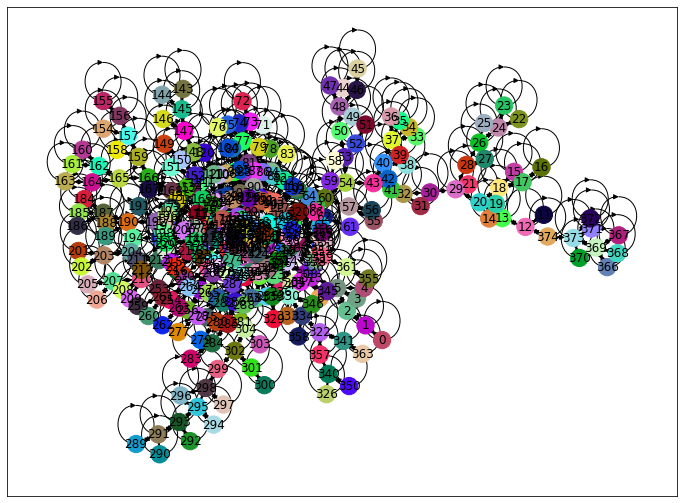

In [10]:
data = val_dataset[4200]
print("# training samples:", len(train_dataset))
print("# validation samples:", len(val_dataset))
print("# vertices:", data.num_nodes)
print("# edges:", data.num_edges)
print("# vertex features:", data.num_node_features)
print("# edge features:", data.num_edge_features)
print("directed graph?:", data.is_directed())
print("isolated vertices?", data.has_isolated_nodes())
print("self-loops?", data.has_self_loops())
print("coalesced?", data.is_coalesced())
print("valid?", data.validate())
plt.figure(figsize=(12, 9))
graph = to_networkx(data, to_undirected=False)
nx.draw_networkx(graph, pos=nx.drawing.kamada_kawai_layout(graph), with_labels=True,
                 node_color=[tuple(torch.rand(3)) for _ in range(375)])

In [12]:
from importlib import reload
import lamah_models
lamah_models = reload(lamah_models)
from lamah_models import FloodMLP, FloodGCN, FloodGRAFFNN

edge_weights = functions.init_edge_weights(HPARAMS["model"]["weight_type"], data)
model = functions.construct_model(HPARAMS, edge_weights)
history = functions.train(model, train_dataset, val_dataset, HPARAMS, on_ipu=True)

Layer (type:depth-idx)                   Param #
FloodGCN                                 1,123
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       3,200
│    └─ReLU: 2-2                         --
├─Linear: 1-2                            129
├─ModuleList: 1-3                        --
│    └─GCNConv: 2-3                      16,512
│    └─GCNConv: 2-4                      16,512
│    └─GCNConv: 2-5                      16,512
│    └─GCNConv: 2-6                      16,512
│    └─GCNConv: 2-7                      16,512
│    └─GCNConv: 2-8                      16,512
│    └─GCNConv: 2-9                      16,512
│    └─GCNConv: 2-10                     16,512
│    └─GCNConv: 2-11                     16,512
│    └─GCNConv: 2-12                     16,512
│    └─GCNConv: 2-13                     16,512
│    └─GCNConv: 2-14                     16,512
│    └─GCNConv: 2-15                     16,512
│    └─GCNConv: 2-16                     16,512
│    └─G

Graph compilation: 100%|██████████| 100/100 [00:02<00:00]


Training on IPU


Training: 100%|██████████| 1274/1274 [00:14<00:00, 87.55it/s, train_loss=1.16e+3]


TypeError: val_step() takes 3 positional arguments but 4 were given

In [ ]:
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
i = history["val_loss"].index(min(history["val_loss"]))
plt.ylim(0,1)
print(f"{history['train_loss'][i]:.4f}/{history['val_loss'][i]:.4f}")

In [13]:
plt.plot([history["model_params"][i]["edge_weights"].std() for i in range(20)])

KeyError: 'edge_weights'